In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.downloader import load

## Dataset

For this project, we will use the [Amazon Fine Food Reviews](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/) dataset. It contains reviews of fine foods from Amazon, including text reviews and ratings. Here's the list of columns in the dataset:

- `Id`: Unique identifier for each review
- `ProductId`: Unique identifier for the product
- `UserId`: Unique identifier for the user
- `ProfileName`: Name of the user profile
- `HelpfulnessNumerator`: Number of helpful votes
- `HelpfulnessDenominator`: Total number of votes
- `Score`: Rating given by the user (1 to 5)
- `Time`: Timestamp of the review
- `Summary`: Summary of the review
- `Text`: Full text of the review

In [2]:
glove_model = load("glove-wiki-gigaword-100")

In [3]:
# df = pd.read_csv("./data/Reviews.csv")
df = pd.read_csv("./data/fine_food_reviews_tokenized.csv")

In [4]:
df.iloc[0].TokenizedText

"['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'product', 'found', 'good', 'quality', 'product', 'look', 'like', 'stew', 'processed', 'meat', 'smell', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']"

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
 10  TokenizedText           568454 non-null  object
dtypes: int64(5), object(6)
memory usage: 47.7+ MB


In [6]:
grouped_by_product = df.groupby("ProductId").size().sort_values(ascending=False)
grouped_by_user = df.groupby("UserId").size().sort_values(ascending=False)

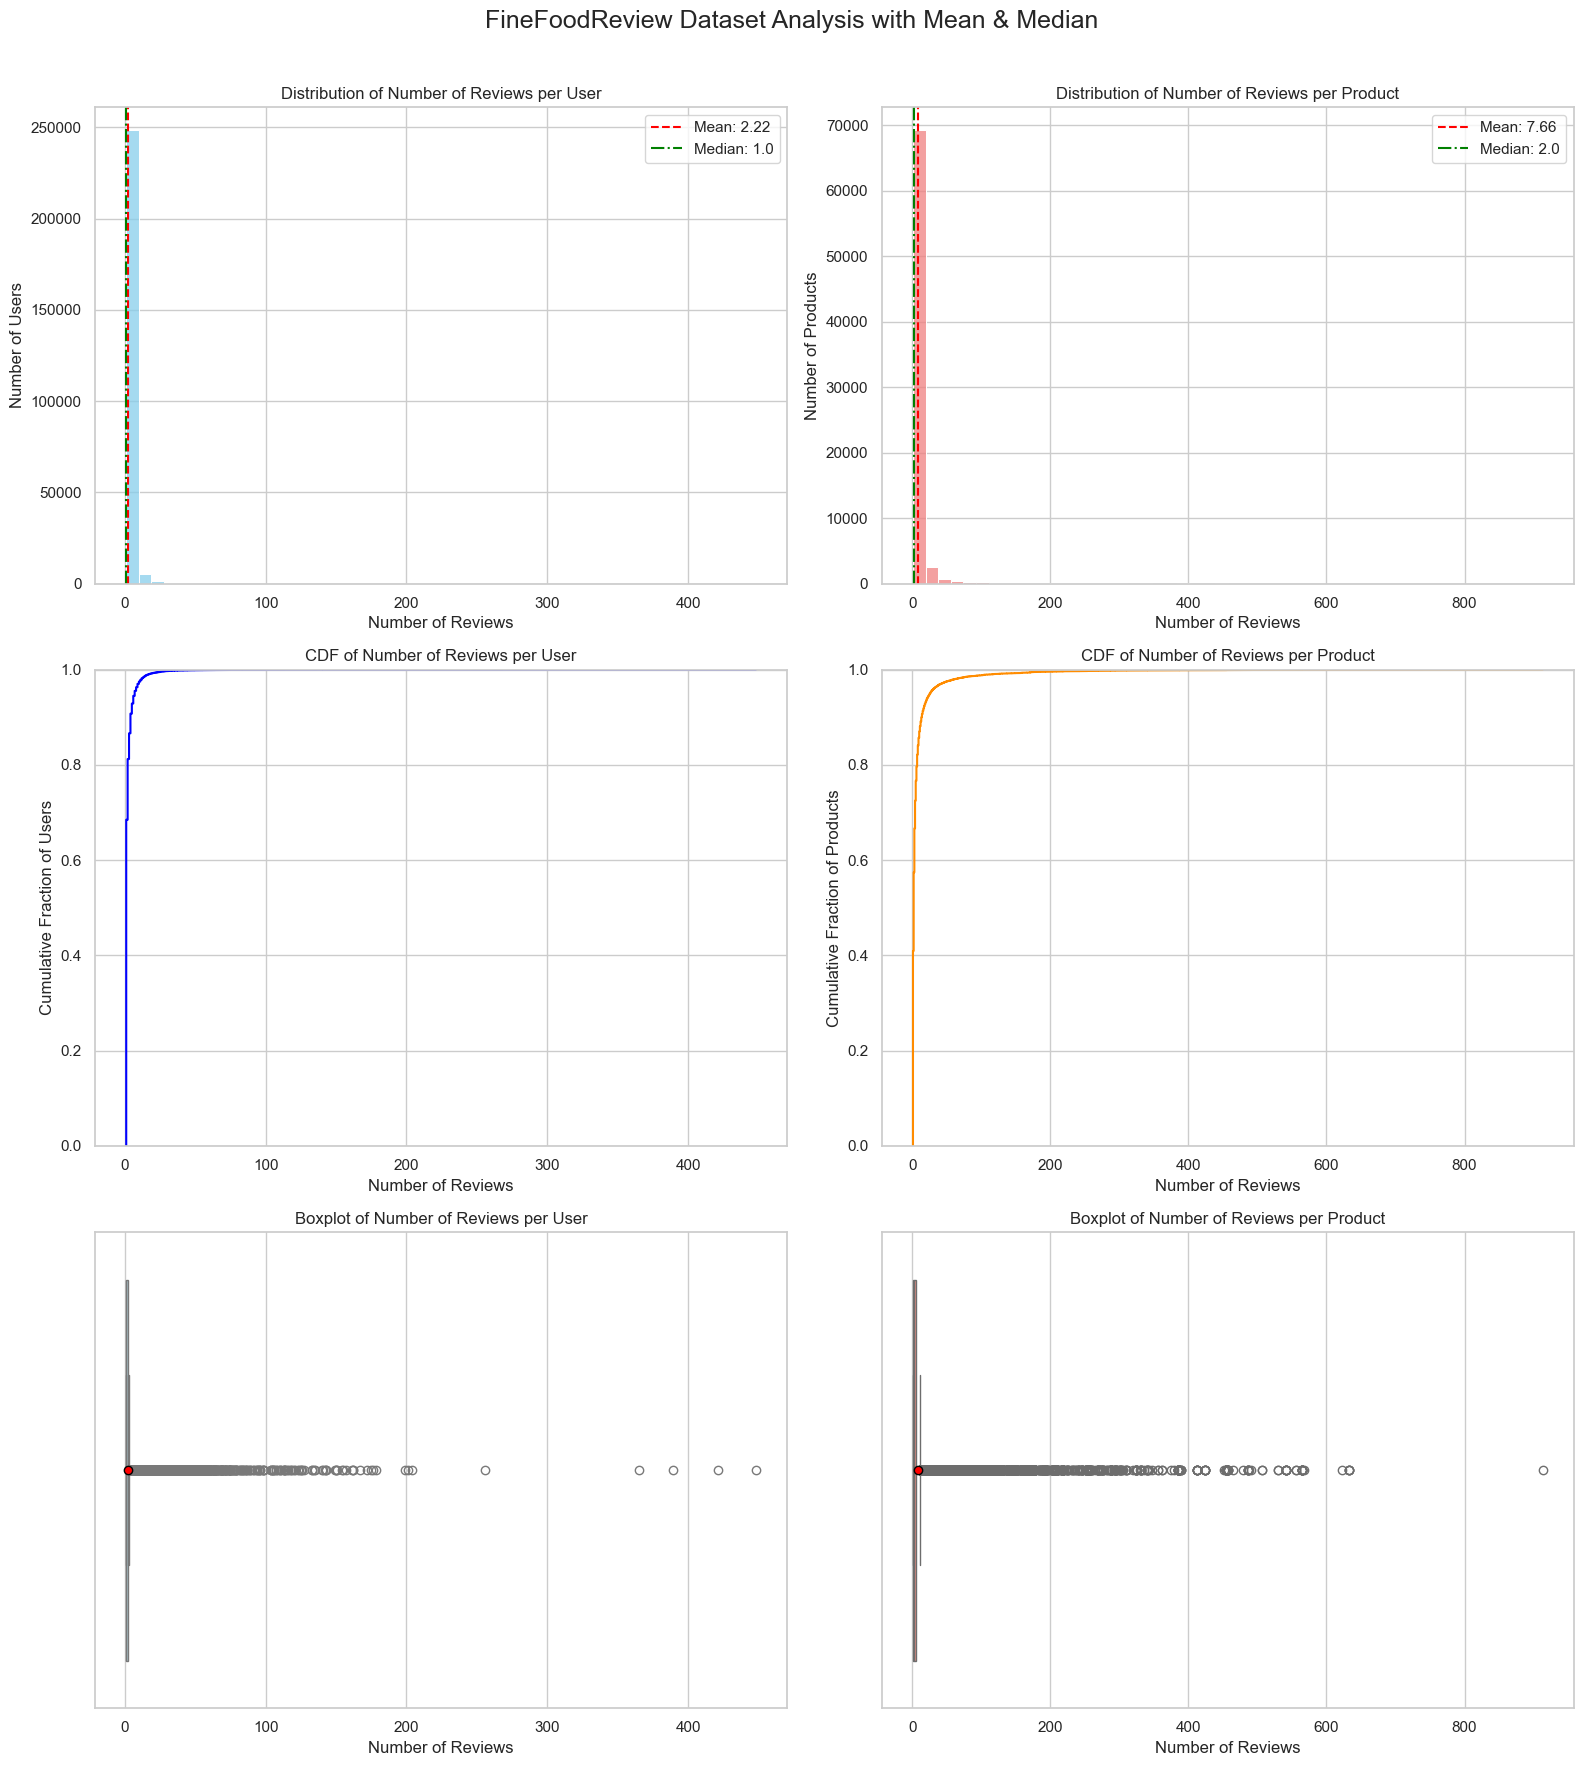

In [7]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("FineFoodReview Dataset Analysis with Mean & Median", fontsize=18)

# 1. Histogram of reviews per user
mean_u = grouped_by_user.mean()
median_u = grouped_by_user.median()
sns.histplot(grouped_by_user.to_numpy(), bins=50, ax=axes[0,0], color="skyblue", kde=False)
axes[0,0].axvline(mean_u, color="red", linestyle="--", label=f"Mean: {mean_u:.2f}")
axes[0,0].axvline(median_u, color="green", linestyle="-.", label=f"Median: {median_u}")
axes[0,0].set_title("Distribution of Number of Reviews per User")
axes[0,0].set_xlabel("Number of Reviews")
axes[0,0].set_ylabel("Number of Users")
axes[0,0].legend()

# 2. Histogram of reviews per product
mean_p = grouped_by_product.mean()
median_p = grouped_by_product.median()
sns.histplot(grouped_by_product.to_numpy(), bins=50, ax=axes[0,1], color="lightcoral", kde=False)
axes[0,1].axvline(mean_p, color="red", linestyle="--", label=f"Mean: {mean_p:.2f}")
axes[0,1].axvline(median_p, color="green", linestyle="-.", label=f"Median: {median_p}")
axes[0,1].set_title("Distribution of Number of Reviews per Product")
axes[0,1].set_xlabel("Number of Reviews")
axes[0,1].set_ylabel("Number of Products")
axes[0,1].legend()

# 3. CDF for users
sns.ecdfplot(grouped_by_user.to_numpy(), ax=axes[1,0], color="blue")
axes[1,0].set_title("CDF of Number of Reviews per User")
axes[1,0].set_xlabel("Number of Reviews")
axes[1,0].set_ylabel("Cumulative Fraction of Users")
axes[1,0].grid(True)


# 4. CDF for products
sns.ecdfplot(grouped_by_product.to_numpy(), ax=axes[1,1], color="darkorange")
axes[1,1].set_title("CDF of Number of Reviews per Product")
axes[1,1].set_xlabel("Number of Reviews")
axes[1,1].set_ylabel("Cumulative Fraction of Products")
axes[1,1].grid(True)

# 5. Boxplot for users
sns.boxplot(x=grouped_by_user, ax=axes[2,0], color="lightblue", showmeans=True,
            meanprops={"marker":"o","markerfacecolor":"red","markeredgecolor":"black"})
axes[2,0].set_title("Boxplot of Number of Reviews per User")
axes[2,0].set_xlabel("Number of Reviews")

# 6. Boxplot for products
sns.boxplot(x=grouped_by_product, ax=axes[2,1], color="salmon", showmeans=True,
            meanprops={"marker":"o","markerfacecolor":"red","markeredgecolor":"black"})
axes[2,1].set_title("Boxplot of Number of Reviews per Product")
axes[2,1].set_xlabel("Number of Reviews")

plt.tight_layout(rect=(0, 0, 1, 0.97))
plt.show()




From the user and product statistics, we can see that the average number of reviews per user is around 2.22, with a maximum of 448 reviews by a single user. For products, the average number of reviews is about 7.66, with a maximum of 913 reviews for a single product. This indicates that while most users review only a few products, some users are very active in reviewing multiple products. Also, looking at the 75%, we can see that 75% of users have reviewed 2 or fewer products, and 75% of products have received 5 or fewer reviews. This suggests a long tail distribution where a few users and products are highly active while the majority are not. It's important to consider these statistics when training models, as they can impact the model's ability to generalize and the importance of certain users or products in the dataset. 


In [8]:
from word_tokenizer import WordTokenizer
tokenizer = WordTokenizer(
            remove_stopwords=True,
            lower_case=True,
            use_lemmatization=True,
        )
def tokenize_reviews(input_df, tkz: WordTokenizer, forced = False):
    if forced or "TokenizedText" not in input_df.columns:
        input_df["TokenizedText"] = input_df["Text"].apply(lambda x: tkz(x, return_tokens=True))
    return input_df



In [9]:
tokenized_df = tokenize_reviews(df, tokenizer)
df = tokenized_df.copy(deep=True)
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,TokenizedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"['bought', 'several', 'vitality', 'canned', 'd..."
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"['product', 'arrived', 'labeled', 'jumbo', 'sa..."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"['confection', 'around', 'century', 'light', '..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,"['looking', 'secret', 'ingredient', 'robitussi..."
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,"['great', 'taffy', 'great', 'price', 'wide', '..."
...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,"['great', 'sesame', 'chickenthis', 'good', 'be..."
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,"[""'m"", 'disappointed', 'flavor', 'chocolate', ..."
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...","['star', 'small', 'give', '1015', 'one', 'trai..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,"['best', 'treat', 'training', 'rewarding', 'do..."


In [10]:
# store the new dataset with tokenized reviews to save time in future runs
df.to_csv("data/fine_food_reviews_tokenized.csv", index=False)

## Glove Embeddings

In [11]:

def get_document_vector(tokens, embedding_index, dim=100):
    """
    Get the document vector for a list of tokens using the GloVe embedding index.
    If a token is not found in the embedding index, it is ignored.
    If no tokens are found, a zero vector of the specified dimension is returned.
    Args:
        tokens (list): List of tokens (words) from the document.
        embedding_index (dict): Dictionary mapping tokens to their GloVe vectors.
        dim (int): Dimension of the GloVe vectors (default is 100).
    Returns:
        np.ndarray: A vector representing the document, averaged from the GloVe vectors of the tokens.
        If no tokens are found in the embedding index, returns a zero vector of the specified
    """
    vecs = []
    for token in tokens:
        if token in embedding_index:
            vecs.append(embedding_index[token])
    if len(vecs) > 0:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(dim)


In [12]:
df['doc_vector'] = df['TokenizedText'].apply(lambda x: get_document_vector(x, glove_model, dim=100))

In [13]:
df.to_csv("data/vectorized_reviews.csv", index=False)
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,TokenizedText,doc_vector
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"['bought', 'several', 'vitality', 'canned', 'd...","[-0.33851287, 0.21322037, 0.24836315, -0.36468..."
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"['product', 'arrived', 'labeled', 'jumbo', 'sa...","[-0.36065146, 0.18845408, 0.2508819, -0.331227..."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"['confection', 'around', 'century', 'light', '...","[-0.32066685, 0.20939136, 0.26405984, -0.32715..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,"['looking', 'secret', 'ingredient', 'robitussi...","[-0.37594515, 0.18041308, 0.2725404, -0.433481..."
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,"['great', 'taffy', 'great', 'price', 'wide', '...","[-0.32971767, 0.1647176, 0.2655249, -0.3575037..."
...,...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,"['great', 'sesame', 'chickenthis', 'good', 'be...","[-0.3154823, 0.20266818, 0.26164705, -0.335125..."
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,"[""'m"", 'disappointed', 'flavor', 'chocolate', ...","[-0.31852943, 0.22567017, 0.26009881, -0.33630..."
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...","['star', 'small', 'give', '1015', 'one', 'trai...","[-0.35161597, 0.18366945, 0.28696948, -0.40566..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,"['best', 'treat', 'training', 'rewarding', 'do...","[-0.35937047, 0.14247337, 0.26726994, -0.45680..."


## TFIDF

In [14]:
# TFIDF

from sklearn.feature_extraction.text import TfidfVectorizer

# If you have 'TokenizedText' as list, join them:
df['JoinedTokens'] = df['TokenizedText'].apply(lambda tokens: ' '.join(eval(tokens)))

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  # adjust max_features
X_tfidf = vectorizer.fit_transform(df['JoinedTokens'])

df['doc_vector_tfidf'] = list(X_tfidf.toarray())

In [15]:
kmeans_tfidf = KMeans(n_clusters=5, random_state=42)
df['Cluster_TFIDF'] = kmeans_tfidf.fit_predict(X_tfidf)

In [16]:
df.to_csv("data/vectorized_reviews.csv", index=False)
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,TokenizedText,doc_vector,JoinedTokens,doc_vector_tfidf,Cluster_TFIDF
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"['bought', 'several', 'vitality', 'canned', 'd...","[-0.33851287, 0.21322037, 0.24836315, -0.36468...",bought several vitality canned dog food produc...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"['product', 'arrived', 'labeled', 'jumbo', 'sa...","[-0.36065146, 0.18845408, 0.2508819, -0.331227...",product arrived labeled jumbo salted peanutsth...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"['confection', 'around', 'century', 'light', '...","[-0.32066685, 0.20939136, 0.26405984, -0.32715...",confection around century light pillowy citrus...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,"['looking', 'secret', 'ingredient', 'robitussi...","[-0.37594515, 0.18041308, 0.2725404, -0.433481...",looking secret ingredient robitussin believe f...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,"['great', 'taffy', 'great', 'price', 'wide', '...","[-0.32971767, 0.1647176, 0.2655249, -0.3575037...",great taffy great price wide assortment yummy ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,"['great', 'sesame', 'chickenthis', 'good', 'be...","[-0.3154823, 0.20266818, 0.26164705, -0.335125...",great sesame chickenthis good better resturant...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,"[""'m"", 'disappointed', 'flavor', 'chocolate', ...","[-0.31852943, 0.22567017, 0.26009881, -0.33630...",'m disappointed flavor chocolate note especial...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...","['star', 'small', 'give', '1015', 'one', 'trai...","[-0.35161597, 0.18366945, 0.28696948, -0.40566...",star small give 1015 one training session trie...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,"['best', 'treat', 'training', 'rewarding', 'do...","[-0.35937047, 0.14247337, 0.26726994, -0.45680...",best treat training rewarding dog good groomin...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2


## Clustering

In [17]:
from sklearn.decomposition import PCA


X = np.vstack(df['doc_vector'].values)
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

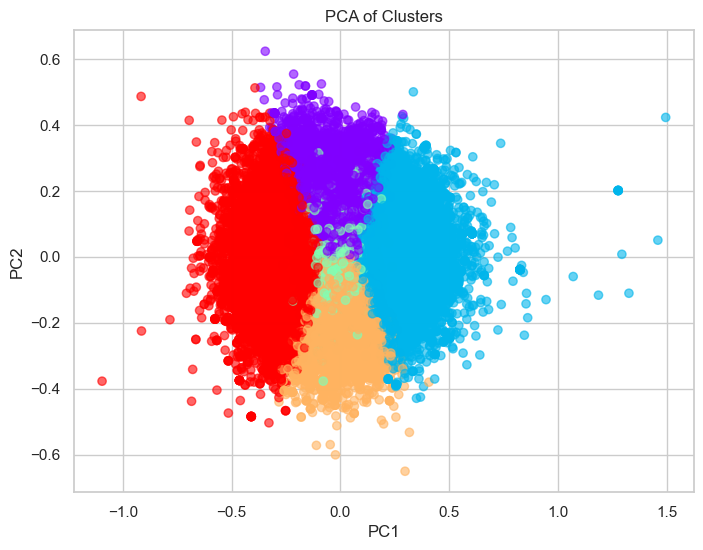

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=df['Cluster'], cmap='rainbow', alpha=0.6)
plt.title("PCA of Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

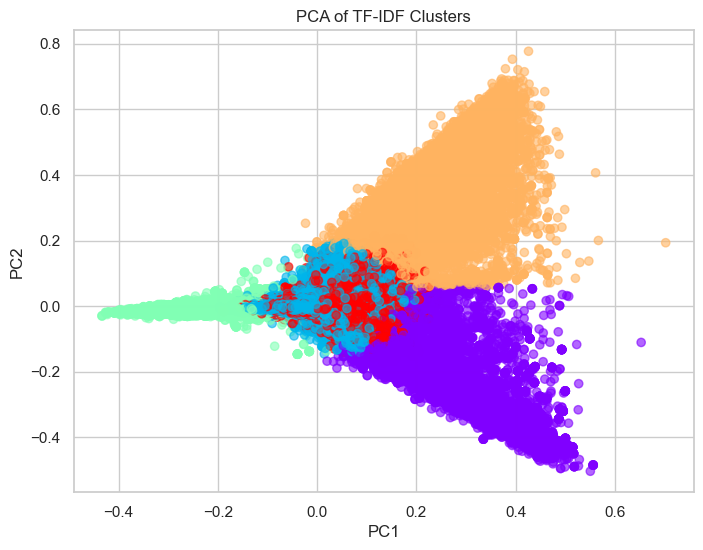

In [19]:
from sklearn.decomposition import PCA

X_tfidf_dense = X_tfidf.toarray()
X_tfidf_pca = PCA(n_components=2).fit_transform(X_tfidf_dense)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(X_tfidf_pca[:,0], X_tfidf_pca[:,1], c=df['Cluster_TFIDF'], cmap='rainbow', alpha=0.6)
plt.title("PCA of TF-IDF Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [20]:
for i in range(5):
    print(f"\nGloVe Cluster {i}")
    print(df[df['Cluster'] == i]['TokenizedText'].sample(3, random_state=42).values)

    print(f"\nTF-IDF Cluster {i}")
    print(df[df['Cluster_TFIDF'] == i]['TokenizedText'].sample(3, random_state=42).values)



GloVe Cluster 0
['[\'arrived\', \'time\', \'good\', \'condition\', \'love\', \'item\', \'ca\', "n\'t", \'seem\', \'find\', \'local\', \'grocery\', \'store\']'
 '[\'rice\', \'taste\', \'good\', \'think\', "\'s", \'best\', \'rice\', "\'ve", \'ever\', \'tasted\', \'love\', \'kind\', \'rice\', \'try\', "\'ll", \'never\', \'go\', \'back\', \'regular\', \'supermarket\', \'rice\']'
 '[\'casserole\', \'dog\', \'thats\', \'right\', \'dog\', \'really\', \'enjoy\', \'theseour\', \'little\', \'chihuahua\', \'picky\', \'eater\', \'really\', "n\'t", \'find\', \'canned\', \'food\', \'helpful\', \'since\', \'wo\', "n\'t", \'eat\', \'put\', \'refrigerator\', \'overnight\', \'perfect\', \'split\', \'single\', \'package\', \'mix\', \'kibble\', \'even\', \'better\', \'travel\', \'easy\', \'open\', \'carry\']']

TF-IDF Cluster 0
['[\'melitta\', \'definitely\', \'good\', \'blend\', \'coffee\', \'might\', \'bit\', \'strong\', \'prefer\', \'milder\', \'flavor\', \'aroma\', \'strong\', \'serf\', \'accentuate\